局部敏感度 - Local Sensitivity

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
# plt.style.use('seaborn-whitegrid')
plt.style.use('fivethirtyeight')
import pandas as pd
import numpy as np

adult = pd.read_csv("adult_with_pii.csv")
def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)
def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

In [2]:
def ls_at_distance(df, u, k):
    return np.abs(u/(len(df) - k + 1))

def dist_to_high_ls(df, u, b):
    k = 0
    
    while ls_at_distance(df, u, k) < b:
        k += 1
    
    return k

In [6]:
def ptr_avg(df, u, b, epsilon, delta, logging=False):
    df_clipped = df.clip(upper=u)
    k = dist_to_high_ls(df_clipped, u, b)

    noisy_distance = laplace_mech(k, 1, epsilon)
    threshold = np.log(2/delta)/(2*epsilon)

    if logging:
        print(f"噪声距离为{noisy_distance}，而门限值为{threshold}")

    if noisy_distance >= threshold:
        return laplace_mech(df_clipped.mean(), b, epsilon)
    else:
        return None

In [7]:
df = adult['Age']
u = 100                    # 设置年龄的上界为100
epsilon = 1                # 设置ε = 1
delta = 1/(len(df)**2)     # 设置δ = 1/n^2
b = 0.005                  # 建议敏感度为0.005

ptr_avg(df, u, b, epsilon, delta, logging=True)

噪声距离为12560.729076545244，而门限值为10.73744412245554


38.57887128840381

局部敏感度并不总优于全局敏感度。对于均值问询，我们用旧回复策略得到的回复效果一般会好得多。这是因为我们可以将均值问询拆分为两个独立的、全局敏感度均有界的问询（求和与计数）。我们同样可以应用全局敏感度实现均值问询。

In [8]:
def gs_avg(df, u, epsilon):
    df_clipped = df.clip(upper=u)
    
    noisy_sum = laplace_mech(df_clipped.sum(), u, .5*epsilon)
    noisy_count = laplace_mech(len(df_clipped), 1, .5*epsilon)
    
    return noisy_sum / noisy_count

In [9]:
gs_avg(adult['Age'], u, epsilon)

38.587691705607796

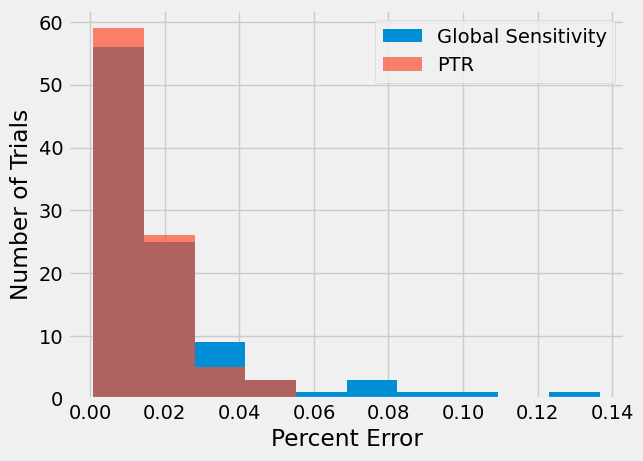

In [11]:
gs_results  = [pct_error(np.mean(adult['Age']), gs_avg(df, u, epsilon)) for i in range(100)]
ptr_results = [pct_error(np.mean(adult['Age']), ptr_avg(df, u, b, epsilon, delta)) for i in range(100)]

_, bins, _ = plt.hist(gs_results, label='Global Sensitivity');
plt.hist(ptr_results, alpha=.7, label='PTR', bins=bins);
plt.xlabel('Percent Error')
plt.ylabel('Number of Trials')
plt.legend();

平滑敏感度

最终敏感度: 0.006142128861863522


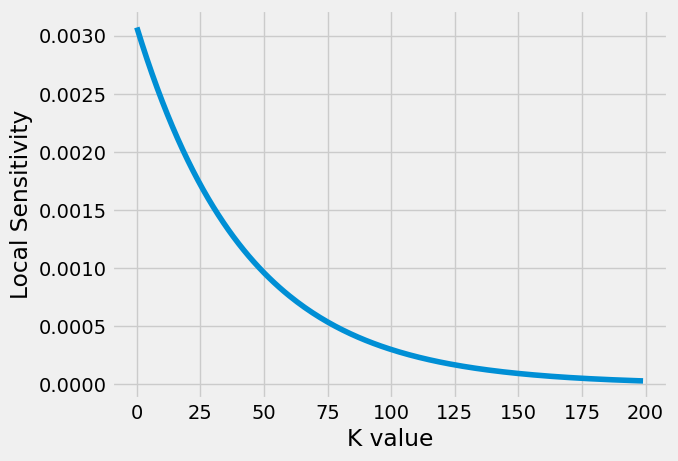

In [12]:
df = adult['Age']
epsilon = 1           # 设置ε = 1
delta = 1/len(df)**2  # 设置δ = 1/n^2

# 步骤1：设置β
beta = epsilon / (2*np.log(2/delta))

# 步骤2：对于不同的k值计算平滑后的局部敏感度
r = [np.exp(- beta * k) * ls_at_distance(df, u, k) for k in range(0,200)]
plt.plot(r);
plt.xlabel('K value')
plt.ylabel('Local Sensitivity');

S = np.max(r)
sensitivity = 2*S
print(f'最终敏感度: {sensitivity}')

"采样-聚合"框架

In [13]:
def f(df):
    return df.mean()

def saa_avg_age(k, epsilon, logging=False):
    df = adult['Age']
    
    # 计算每个数据块应包含的行数
    chunk_size = int(np.ceil(df.shape[0] / k))
    
    if logging:
        print(f'数据块大小: {chunk_size}')
        
    # 步骤1：将`df`拆分为数据块
    xs      = [df[i:i+chunk_size] for i in range(0,df.shape[0],chunk_size)]
    
    # 步骤2：在每个x_i上执行f，并裁剪输出值
    answers = [f(x_i) for x_i in xs]
    
    u = 80
    l = 20
    clipped_answers = np.clip(answers, l, u)
    
    # 步骤3：计算输出均值，并增加噪声
    noisy_mean = laplace_mech(np.mean(clipped_answers), (u-l)/k, epsilon)
    return noisy_mean

saa_avg_age(600, 1, logging=True)

数据块大小: 55


38.38174271582113

In [14]:
def plot_results(k):
    df = adult['Age']
    _, bins, _ = plt.hist([pct_error(np.mean(df), saa_avg_age(k, epsilon)) for i in range(100)]);
    plt.hist([pct_error(np.mean(df), gs_avg(df, u, epsilon)) for i in range(100)], alpha=.7, bins=bins);

Text(0, 0.5, 'Attempts')

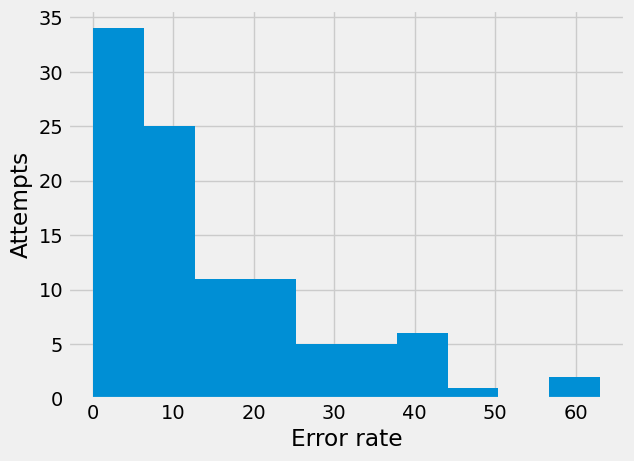

In [16]:
# k = 10；全局敏感度的回复结果准确性*非常*好
plot_results(10)
plt.xlabel('Error rate')
plt.ylabel('Attempts')

Text(0, 0.5, 'Attempts')

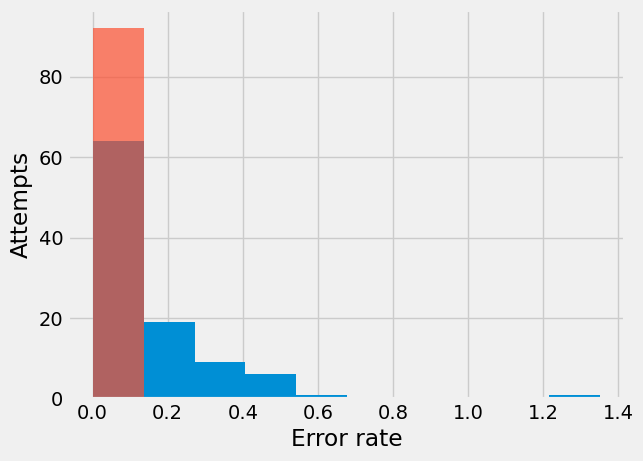

In [18]:
# k = 1000；全局敏感度的回复结果准确性仍然比较好
plot_results(1000)
plt.xlabel('Error rate')
plt.ylabel('Attempts')

Text(0, 0.5, 'Attempts')

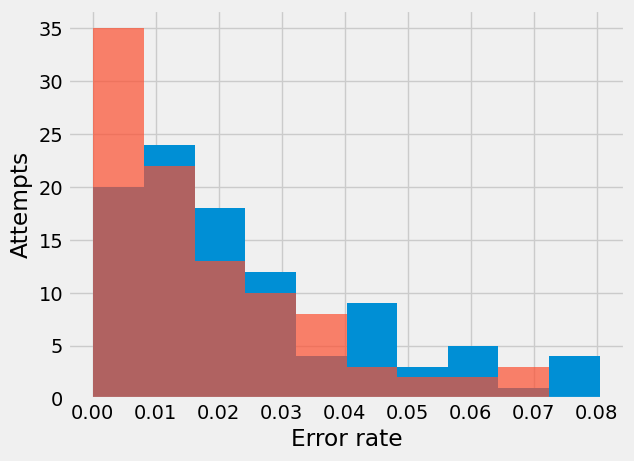

In [19]:
# k = 6000；"采样-聚合"框架的回复结果接近全局敏感度的回复结果了！
plot_results(6000)
plt.xlabel('Error rate')
plt.ylabel('Attempts')